# ADS 509 Assignment 2.1: Tokenization, Normalization, Descriptive Statistics 

This notebook holds Assignment 2.1 for Module 2 in ADS 509, Applied Text Mining. Work through this notebook, writing code and answering questions where required. 

In the previous assignment you put together Twitter data and lyrics data on two artists. In this assignment we explore some of the textual features of those data sets. If, for some reason, you did not complete that previous assignment, data to use for this assignment can be found in the assignment materials section of Blackboard. 

This assignment asks you to write a short function to calculate some descriptive statistics on a piece of text. Then you are asked to find some interesting and unique statistics on your corpora. 


## General Assignment Instructions

These instructions are included in every assignment, to remind you of the coding standards for the class. Feel free to delete this cell after reading it. 

One sign of mature code is conforming to a style guide. We recommend the [Google Python Style Guide](https://google.github.io/styleguide/pyguide.html). If you use a different style guide, please include a cell with a link. 

Your code should be relatively easy-to-read, sensibly commented, and clean. Writing code is a messy process, so please be sure to edit your final submission. Remove any cells that are not needed or parts of cells that contain unnecessary code. Remove inessential `import` statements and make sure that all such statements are moved into the designated cell. 

Make use of non-code cells for written commentary. These cells should be grammatical and clearly written. In some of these cells you will have questions to answer. The questions will be marked by a "Q:" and will have a corresponding "A:" spot for you. *Make sure to answer every question marked with a `Q:` for full credit.* 


In [169]:
import os
import glob
import re
import emoji
import pandas as pd
import numpy as np
import requests
from collections import Counter, defaultdict
import nltk
from nltk.corpus import stopwords
from string import punctuation

In [178]:
# Add any additional import statements you need here
from lexical_diversity import lex_div as ld
import math
import seaborn as sns
import matplotlib.pyplot as plt
from pandasql import sqldf
from bs4 import BeautifulSoup as bs

In [3]:
# change `data_location` to the location of the folder on your machine.
data_location = "/Users/nima/Downloads/"

# These subfolders should still work if you correctly stored the 
# data from the Module 1 assignment
twitter_folder = "twitter/"
lyrics_folder = "lyrics/"

In [4]:
def descriptive_stats(tokens, most_common_tokens_number = 5, verbose=True) :
    """
        Given a list of tokens, print number of tokens, number of unique tokens, 
        number of characters, lexical diversity (https://en.wikipedia.org/wiki/Lexical_diversity), 
        and num_tokens most common tokens. Return a list with the number of tokens, number
        of unique tokens, lexical diversity, and number of characters. 
    
    """

    # Fill in the correct values here. 
    num_tokens = sum(Counter(tokens).values())
    num_unique_tokens = len(Counter(tokens))
    
        
    def lexical_diversity(tokens, split_char = ' '):
        sentence = ' '.join(tokens)
        flt = ld.flemmatize(sentence)
        return ld.ttr(flt)
    
    lexical_diversity = lexical_diversity(tokens)
    
    num_characters = sum([len(t) for t in tokens])
        
    if verbose :        
        print(f"There are {num_tokens} tokens in the data.")
        print(f"There are {num_unique_tokens} unique tokens in the data.")
        print(f"There are {num_characters} characters in the data.")
        print(f"The lexical diversity is {lexical_diversity:.3f} in the data.")
    
        # print the five most common tokens
        most_common_tokens_list = Counter(tokens).most_common(most_common_tokens_number)
        print(f'\nMost Common Tokens are:\n{most_common_tokens_list}')

        
    return([num_tokens, num_unique_tokens,
            lexical_diversity,
            num_characters])
    

In [5]:
text = """here is some example text with other example text here in this text""".split()

assert(descriptive_stats(text, verbose=True)[0] == 13)
assert(descriptive_stats(text, verbose=False)[1] == 9)
assert(abs(descriptive_stats(text, verbose=False)[2] - 0.69) < 0.02)
assert(descriptive_stats(text, verbose=False)[3] == 55)


There are 13 tokens in the data.
There are 9 unique tokens in the data.
There are 55 characters in the data.
The lexical diversity is 0.692 in the data.

Most Common Tokens are:
[('text', 3), ('here', 2), ('example', 2), ('is', 1), ('some', 1)]


Q: Why is it beneficial to use assertion statements in your code? 

A: It can be used as safety net. Eventhough the function may return answer, assert would raise an error and the program will stop running if specified condition is not met.

## Data Input

Now read in each of the corpora. For the lyrics data, it may be convenient to store the entire contents of the file to make it easier to inspect the titles individually, as you'll do in the last part of the assignment. In the solution, I stored the lyrics data in a dictionary with two dimensions of keys: artist and song. The value was the file contents. A data frame would work equally well. 

For the Twitter data, we only need the description field for this assignment. Feel free all the descriptions read it into a data structure. In the solution, I stored the descriptions as a dictionary of lists, with the key being the artist. 




In [6]:
# Read in the lyrics data
lyrics = pd.DataFrame()

folders = os.listdir(data_location + lyrics_folder)
artists_names = [folder for folder in folders if folder[0] != "."]

def read_content(row, parent_fld):
    if row.file_name[0] == ".": return None
        
    with open(parent_fld + row.artist_name + '/' + row.file_name) as f:
        return f.read()
    
for artist_name in artists_names:
    songs = os.listdir(data_location + lyrics_folder + artist_name)
    df = pd.DataFrame(songs, columns=['file_name'])
    df['artist_name'] = artist_name
    df['content'] = df.apply(read_content, parent_fld = data_location + lyrics_folder, axis=1)

    lyrics = pd.concat([lyrics, df], ignore_index=True)
    
lyrics.dropna(subset=['content'], inplace=True)
lyrics

,file_name,artist_name,content
0,samiyusuf_thecaveofhira.txt,sami_yusuf,<i>[Chorus]</i>\nHayya ‘ibad Allah\n(Come O se...
1,samiyusuf_yamustafa.txt,sami_yusuf,"Mustafa, Mustafa, Mustafa.\nYa Mustafa ya Must..."
3,samiyusuf_myonlywishinterlude.txt,sami_yusuf,"All your armies, all your fighters\nAll your t..."
4,samiyusuf_whoisthelovedone.txt,sami_yusuf,Who is the Loved One? Allah\nWho is Ar-Rahman?...
5,samiyusuf_foreverpalestine.txt,sami_yusuf,Mother don’t cry for me I am heading off to wa...
6,samiyusuf_meditation.txt,sami_yusuf,Assalatu wa as-salamu ‘alayk\n‘alayka ya Rasul...
7,samiyusuf_myummahintro.txt,sami_yusuf,Aynal ummah?\nAynal ummah?\n\nRabbana unsurna\...
8,samiyusuf_myummah.txt,sami_yusuf,"My ummah, my ummah\nHe will say\nRasulullah on..."
9,samiyusuf_motherarabic.txt,sami_yusuf,Blessed is your face\nBlessed is your name\nMy...
10,samiyusuf_dua.txt,sami_yusuf,Ne guzel yaratmissin nimetlerini\nbiz kullarin...


In [7]:
# Read in the twitter data

tweets = pd.DataFrame()

folders = os.listdir(data_location + twitter_folder)
twitter_folders = [folder for folder in folders if 'follower_data' in folder]

for artist_name in twitter_folders:
    df = pd.read_csv(data_location + twitter_folder + '/' + artist_name,  delimiter='\t')
    df['artist_name'] = artist_name.split('_')[0]
    
    tweets = pd.concat([tweets, df], ignore_index=True)
    
tweets

,user_id,username,name,location,followers_count,following_count,description,artist_name
0,1550223388798509061,mustafa24saif,mustafa_saif,None,93.0,1412.0,you are not alone I stand by you-|from Syria|l...,MaherZains
1,1460650486386892811,AliHass56081302,Kushesha,"Mombasa, kenya",9.0,91.0,Kushesha,MaherZains
2,1568604519101075456,bhayaKhan3,bhaya Khan,None,3.0,122.0,NaN,MaherZains
3,1276401246,tjJNG,Dj_Jerico,None,1.0,71.0,NaN,MaherZains
4,762043816757125120,motasem_naji,معتصم ناجي,None,39.0,386.0,NaN,MaherZains
...,...,...,...,...,...,...,...,...
406180,4297693043,putriyangke2,Noer Halimah,None,1.0,35,None,SamiYusuf
406181,4566244937,bandtek3,بندر,None,5.0,77,None,SamiYusuf
406182,4569975934,AboAns102030,Sayed 3bd al3ty,"Ismalia, Egypt",27.0,78,None,SamiYusuf
406183,4579557923,asmar19444,asmar1944@yahoo.com,None,2.0,33,None,SamiYusuf


## Data Cleaning

Now clean and tokenize your data. Remove punctuation chacters (available in the `punctuation` object in the `string` library), split on whitespace, fold to lowercase, and remove stopwords. Store your cleaned data, which must be accessible as an interable for `descriptive_stats`, in new objects or in new columns in your data frame. 



In [8]:
punctuation = set(punctuation) # speeds up comparison
punct_pattern = re.compile("[" + re.escape("".join(punctuation)) + "]")

In [9]:
def add_space_after_emoji(text):

    text_section = list()
    for i, char in enumerate(text):
        if emoji.is_emoji(char):
            text_section.append(' ' + text[i] + ' ')
        else:
            text_section.append(text[i])
        
        if (ZERO_WIDTH_JOINER:='\u200d') in text_section:
            text_section.remove(ZERO_WIDTH_JOINER)
         
    return ''.join(text_section)
    
def clean_string(text):
    if pd.isnull(text):
        return text
            
    remove_words = stopwords.words("english") + ['️','',' ']
    text = text.replace('|', ' ').replace('\n',' ')

    text = re.sub(punct_pattern, '', text)
    text = add_space_after_emoji(text)
    text_tokens = text.split(' ')
    text = [word.lower() for word in text_tokens]
    text = [word for word in text if not word in remove_words]
    return text
      

In [10]:
# create your clean twitter data here
tweets['description_clean'] = tweets.description.apply(clean_string)
tweets.head(20)

,user_id,username,name,location,followers_count,following_count,description,artist_name,description_clean
0,1550223388798509061,mustafa24saif,mustafa_saif,None,93.0,1412.0,you are not alone I stand by you-|from Syria|l...,MaherZains,"[alone, stand, syria, live, germany, 🇩🇪, music..."
1,1460650486386892811,AliHass56081302,Kushesha,"Mombasa, kenya",9.0,91.0,Kushesha,MaherZains,[kushesha]
2,1568604519101075456,bhayaKhan3,bhaya Khan,None,3.0,122.0,NaN,MaherZains,NaN
3,1276401246,tjJNG,Dj_Jerico,None,1.0,71.0,NaN,MaherZains,NaN
4,762043816757125120,motasem_naji,معتصم ناجي,None,39.0,386.0,NaN,MaherZains,NaN
5,913036568209768468,JasmineMohdDea2,Jasmine Mohd Dean,Sabah Malaysia,8.0,138.0,NaN,MaherZains,NaN
6,1529961815941210129,Ibnibnali1,Ibnibnali,None,0.0,15.0,محبوب الكل,MaherZains,"[محبوب, الكل]"
7,1370757683935117324,SalwaSa29618342,Salwa Sayed,None,2.0,23.0,💐💐❤️,MaherZains,"[💐, 💐, ❤]"
8,1849152960,mimosimo67,Simo mimo,Algeria,31.0,292.0,aime la litteratures le sport poete,MaherZains,"[aime, la, litteratures, le, sport, poete]"
9,1565873125706825729,tassbazeed,Tasneem Bazeed,El-Mansoura🕊️,20.0,187.0,Mema🐣💙||your fav engineer👷‍♀️,MaherZains,"[mema, 🐣, 💙, fav, engineer, 👷, ♀]"


In [11]:
# create your clean lyrics data here

lyrics['content_clean'] = lyrics.content.apply(clean_string)
lyrics.head(20)

,file_name,artist_name,content,content_clean
0,samiyusuf_thecaveofhira.txt,sami_yusuf,<i>[Chorus]</i>\nHayya ‘ibad Allah\n(Come O se...,"[ichorusi, hayya, ‘ibad, allah, come, servants..."
1,samiyusuf_yamustafa.txt,sami_yusuf,"Mustafa, Mustafa, Mustafa.\nYa Mustafa ya Must...","[mustafa, mustafa, mustafa, ya, mustafa, ya, m..."
3,samiyusuf_myonlywishinterlude.txt,sami_yusuf,"All your armies, all your fighters\nAll your t...","[armies, fighters, tanks, soldiers, boy, holdi..."
4,samiyusuf_whoisthelovedone.txt,sami_yusuf,Who is the Loved One? Allah\nWho is Ar-Rahman?...,"[loved, one, allah, arrahman, allah, almannan,..."
5,samiyusuf_foreverpalestine.txt,sami_yusuf,Mother don’t cry for me I am heading off to wa...,"[mother, don’t, cry, heading, war, god, almigh..."
6,samiyusuf_meditation.txt,sami_yusuf,Assalatu wa as-salamu ‘alayk\n‘alayka ya Rasul...,"[assalatu, wa, assalamu, ‘alayk, ‘alayka, ya, ..."
7,samiyusuf_myummahintro.txt,sami_yusuf,Aynal ummah?\nAynal ummah?\n\nRabbana unsurna\...,"[aynal, ummah, aynal, ummah, rabbana, unsurna,..."
8,samiyusuf_myummah.txt,sami_yusuf,"My ummah, my ummah\nHe will say\nRasulullah on...","[ummah, ummah, say, rasulullah, day, even, tho..."
9,samiyusuf_motherarabic.txt,sami_yusuf,Blessed is your face\nBlessed is your name\nMy...,"[blessed, face, blessed, name, beloved, blesse..."
10,samiyusuf_dua.txt,sami_yusuf,Ne guzel yaratmissin nimetlerini\nbiz kullarin...,"[ne, guzel, yaratmissin, nimetlerini, biz, kul..."


In [12]:
# remove the rows with no description/lyrics
tweets = tweets[tweets.description != 'None']
tweets = tweets[tweets.description.notnull()]
tweets.reset_index(drop=True, inplace=True)

def gather_descriptive_stats(df, artist, category):
    df_stat = pd.DataFrame()
    for idx, row in enumerate(df):
        stat = descriptive_stats(row, verbose=False)
        df_stat.loc[idx, 'tokens_count'] = stat[0]
        df_stat.loc[idx, 'unique_tokens_count'] = stat[1]
        df_stat.loc[idx, 'characters_count'] = stat[3]
        df_stat.loc[idx, 'lexical_diversity'] = stat[2]
    
    df_stat['artist'] = artist
    df_stat['category'] = category
    return  df_stat

stats_all = pd.DataFrame()
for artist in tweets.artist_name.unique():
    df = tweets.loc[tweets.artist_name == artist,'description_clean']
    info = gather_descriptive_stats(df, artist = artist, category = 'tweets')
    stats_all = pd.concat([stats_all,info])

for artist in lyrics.artist_name.unique():
    df = lyrics.loc[lyrics.artist_name == artist,'content_clean']
    info = gather_descriptive_stats(df, artist = artist, category = 'lyrics')
    stats_all = pd.concat([stats_all,info])
    
stats_all   

,tokens_count,unique_tokens_count,characters_count,lexical_diversity,artist,category
0,10.0,10.0,38.0,1.000000,MaherZains,tweets
1,1.0,1.0,8.0,1.000000,MaherZains,tweets
2,2.0,2.0,9.0,1.000000,MaherZains,tweets
3,3.0,2.0,3.0,0.666667,MaherZains,tweets
4,6.0,6.0,30.0,1.000000,MaherZains,tweets
...,...,...,...,...,...,...
20,194.0,95.0,978.0,0.479381,maher_zain,lyrics
21,151.0,62.0,758.0,0.397351,maher_zain,lyrics
22,423.0,123.0,2118.0,0.286052,maher_zain,lyrics
23,178.0,59.0,808.0,0.325843,maher_zain,lyrics


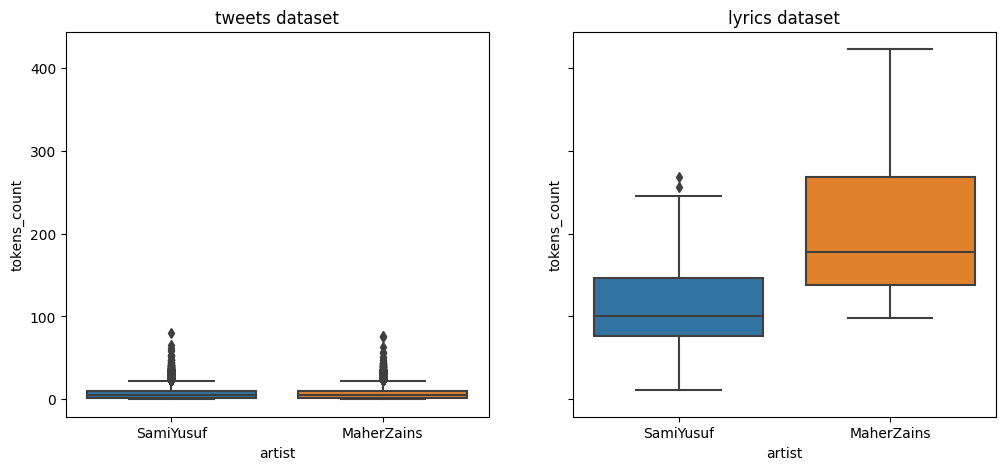

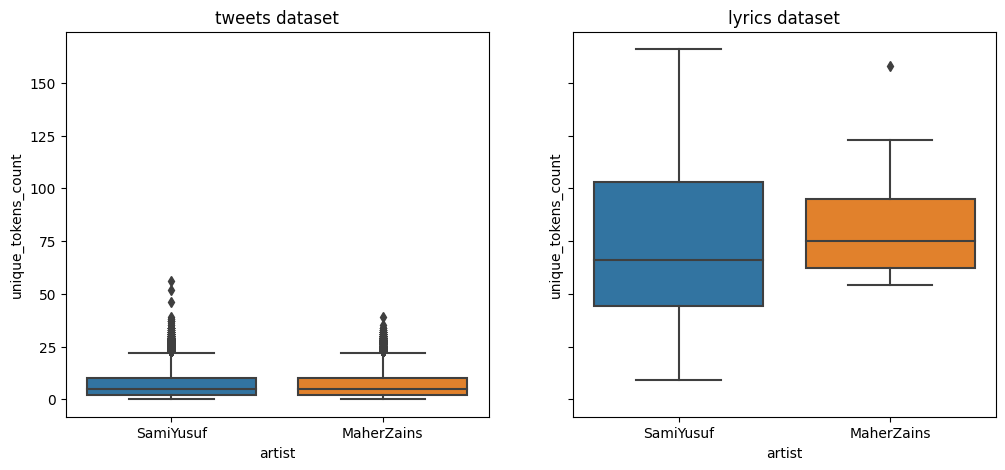

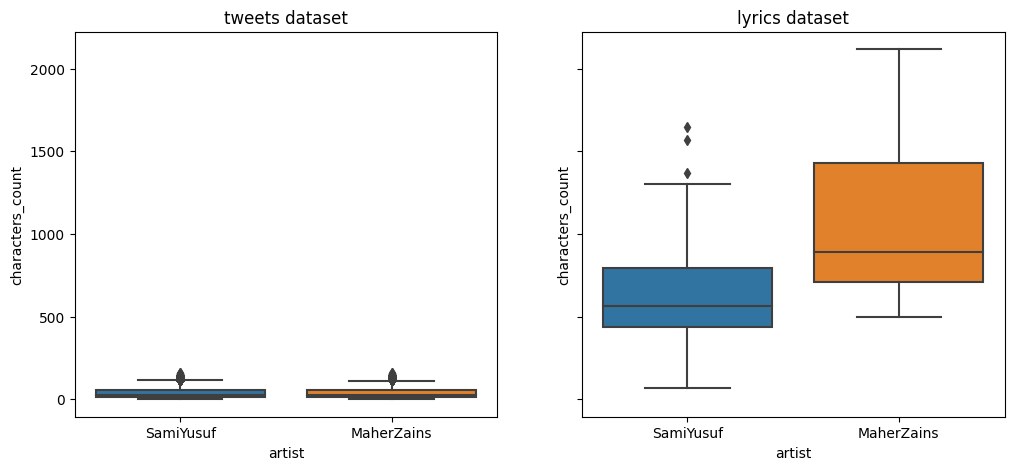

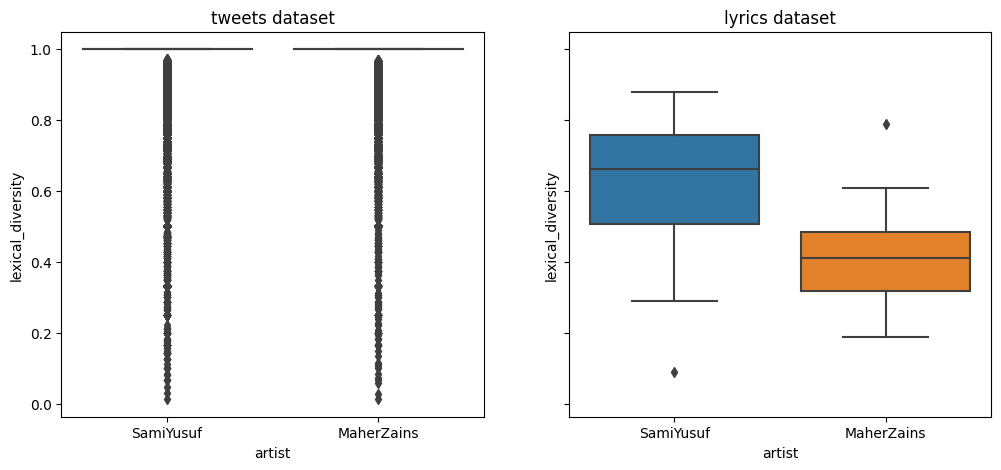

In [13]:
standardize_names = {'maher_zain':'MaherZains','sami_yusuf':'SamiYusuf'}

stats_all = stats_all.replace({'artist':standardize_names})
df_plot = stats_all.sort_values('artist', ascending=False)


for col in ['tokens_count', 'unique_tokens_count', 'characters_count', 'lexical_diversity']:
    fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(12, 5))

    sns.boxplot(data=df_plot[df_plot.category == 'tweets'], x="artist", y=col, ax=ax1)
    sns.boxplot(data=df_plot[df_plot.category == 'lyrics'], x="artist", y=col, ax=ax2)

    ax1.set_title('tweets dataset')
    ax2.set_title('lyrics dataset')
    plt.show()

## Basic Descriptive Statistics

Call your `descriptive_stats` function on both your lyrics data and your twitter data and for both artists (four total calls). 

Q: How do you think the "top 5 words" would be different if we left stopwords in the data? 

A: words such as ("a", "the", "that", "for", "in")

---

Q: What were your prior beliefs about the lexical diversity between the artists? Does the difference (or lack thereof) in lexical diversity between the artists conform to your prior beliefs? 

A: It can be observed that Maher Zain tends to re-use same words more often than Sami Yusuf. Difference in the lexical diversity between the artists is not something that I had noticed since both artists repeat the same words in their songs many times. It is intresting to see that Maher Zain repeat same words more often than Sami Yusuf.



## Specialty Statistics

The descriptive statistics we have calculated are quite generic. You will now calculate a handful of statistics tailored to these data.

1. Ten most common emojis by artist in the twitter descriptions.
1. Ten most common hashtags by artist in the twitter descriptions.
1. Five most common words in song titles by artist. 
1. For each artist, a histogram of song lengths (in terms of number of tokens) 

We can use the `emoji` library to help us identify emojis and you have been given a function to help you.


In [14]:
def is_emoji(s):
    return(emoji.is_emoji(s))

assert(is_emoji("❤️"))
assert(not is_emoji(":-)"))

### Emojis 😁

What are the ten most common emojis by artist in the twitter descriptions? 


In [152]:
# Your code here
emoji_df = pd.DataFrame()
for idx, row in tweets.iterrows():
    emoji_used = [char for char in row.description_clean if is_emoji(char)]
    
    if emoji_used:
        for emoji_char in emoji_used:
            last_row = len(emoji_df)
            emoji_df.loc[last_row, 'emoji_symbol'] = emoji_char
            emoji_df.loc[last_row, 'artist'] = row.artist_name
 
emoji_df           

,emoji_symbol,artist
0,🇩🇪,MaherZains
1,💙,MaherZains
2,🎼,MaherZains
3,🌹,MaherZains
4,💐,MaherZains
...,...,...
111139,🙈,SamiYusuf
111140,😍,SamiYusuf
111141,😄,SamiYusuf
111142,😅,SamiYusuf


In [164]:
for artist in emoji_df.artist.unique():
    query = f"""
        SELECT 
            emoji_symbol,
            COUNT(emoji_symbol) AS Count
        FROM emoji_df
        GROUP BY emoji_symbol, artist
        HAVING artist = '{artist}'
        ORDER BY Count DESC
        LIMIT 10
        """ 
    print(f"TOP 10 emoji symbol used in description of %s's followers:\n\n%s\n\n" % (artist, sqldf(query)))

TOP 10 emoji symbol used in description of MaherZains's followers:

  emoji_symbol  Count
0            ❤   6466
1            ♥   5107
2            😍   1175
3            ✌   1143
4            🏻    875
5            💙    826
6            🌸    772
7            💪    665
8            ✋    662
9            ☺    638


TOP 10 emoji symbol used in description of SamiYusuf's followers:

  emoji_symbol  Count
0            ❤   7276
1            ♥   2009
2            💙   1535
3            😍   1489
4            🏻   1222
5            🌸   1083
6            💜   1058
7            ✨    997
8            ✌    965
9            🎓    804




### Hashtags

What are the ten most common hashtags by artist in the twitter descriptions? 


In [101]:
# Your code here

hashtags_df = pd.DataFrame()

for idx, row in tweets.iterrows(): 
    hashtags = re.findall('#[A-Za-z0-9\-\.\_]+', row.description)
    if hashtags:
        for hashtag in hashtags:
            last_row = len(hashtags_df)
            hashtags_df.loc[last_row, 'hashtag'] = hashtag.lower()
            hashtags_df.loc[last_row, 'artist'] = row.artist_name

hashtags_df       

,hashtag,artist
0,#lawan,MaherZains
1,#kerajaangagal,MaherZains
2,#keluargagagal,MaherZains
3,#authenticbagjewelries,MaherZains
4,#officer,MaherZains
...,...,...
18340,#enthusiastic.,SamiYusuf
18341,#ahlawy,SamiYusuf
18342,#madridy,SamiYusuf
18343,#amr,SamiYusuf


In [167]:
for artist in hashtags_df.artist.unique():
    query = f"""
        SELECT 
            hashtag,
            COUNT(hashtag) AS Count
        FROM hashtags_df
        GROUP BY hashtag, artist
        HAVING artist = '{artist}'
        ORDER BY Count DESC
        LIMIT 10
        """         
        
    print(f"TOP 10 Hashtag used in description of %s's followers:\n\n%s\n\n" % (artist, sqldf(query)))

TOP 10 Hashtag used in description of MaherZains's followers:

          hashtag  Count
0         #muslim     67
1        #zamalek     52
2           #ahly     48
3           #love     47
4  #freepalestine     45
5          #music     36
6         #ahlawy     31
7         #alahly     31
8        #3alahwa     30
9     #pharmacist     30


TOP 10 Hashtag used in description of SamiYusuf's followers:

                      hashtag  Count
0       #karabakhisazerbaijan    311
1              #freepalestine    100
2                     #muslim     63
3                       #love     45
4  #medeniyettasavvuruyolculu     34
5                      #music     33
6                        #mto     31
7                #freekashmir     29
8                   #pakistan     27
9                        #pti     27




### Song Titles

What are the five most common words in song titles by artist? The song titles should be on the first line of the lyrics pages, so if you have kept the raw file contents around, you will not need to re-read the data.


In [261]:
# Your code here
artists = {'maher_zain':"https://www.azlyrics.com/m/maherzain.html",
           'sami_yusuf':"https://www.azlyrics.com/s/samiyusuf.html"}

songs_df = pd.DataFrame()

for artist,link in artists.items():
    r = requests.get(link)
    soup = bs(r.content, "html.parser") 
    all_text = soup.find("div", class_ = "col-xs-12 col-lg-8 text-center") 
    sub_section = bs(str(all_text), "html.parser") 
    all_songs = sub_section.findAll("div", class_ = "listalbum-item") 

    for song_line in all_songs:
        try:
            title = [title for title in song_line.find("a")][0]
            last_row = len(songs_df)
            songs_df.loc[last_row, 'artist'] = artist
            songs_df.loc[last_row, 'title'] = title
        except:
            continue

songs_df 

,artist,title
0,maher_zain,Always Be There
1,maher_zain,Ya Nabi Salam Alayka
2,maher_zain,Insha Allah
3,maher_zain,Palestine Will Be Free
4,maher_zain,Thank You Allah
...,...,...
222,sami_yusuf,My Song
223,sami_yusuf,Silent Words
224,sami_yusuf,The 99 Names
225,sami_yusuf,The Gift Of Love


In [266]:
songs_df['title_clean'] = songs_df.title.apply(clean_string)
word_in_title_df = pd.DataFrame()

for idx, row in songs_df.iterrows():
    for word in row.title_clean:
        if not word == 'version':
            last_row = len(word_in_title_df)
            word_in_title_df.loc[last_row, 'word'] = word.lower()
            word_in_title_df.loc[last_row, 'artist'] = row.artist    

word_in_title_df

,word,artist
0,always,maher_zain
1,ya,maher_zain
2,nabi,maher_zain
3,salam,maher_zain
4,alayka,maher_zain
...,...,...
410,names,sami_yusuf
411,gift,sami_yusuf
412,love,sami_yusuf
413,praised,sami_yusuf


In [267]:
for artist in word_in_title_df.artist.unique():
    query = f"""
        SELECT 
            word,
            COUNT(word) AS Count
        FROM word_in_title_df
        GROUP BY word, artist
        HAVING artist = '{artist}'
        ORDER BY Count DESC
        LIMIT 5
        """         
        
    print(f"TOP 5 word used in %s's titles:\n\n%s\n\n" % (artist, sqldf(query)))

TOP 5 word used in maher_zain's titles:

      word  Count
0    allah     10
1      one      7
2  turkish      7
3   arabic      6
4      day      6


TOP 5 word used in sami_yusuf's titles:

     word  Count
0      ya      7
1  arabic      4
2    came      4
3   allah      3
4   never      3




### Song Lengths

For each artist, a histogram of song lengths (in terms of number of tokens). If you put the song lengths in a data frame with an artist column, matplotlib will make the plotting quite easy. An example is given to help you out. 


artist
Artist 1    AxesSubplot(0.125,0.11;0.775x0.77)
Artist 2    AxesSubplot(0.125,0.11;0.775x0.77)
Name: length, dtype: object

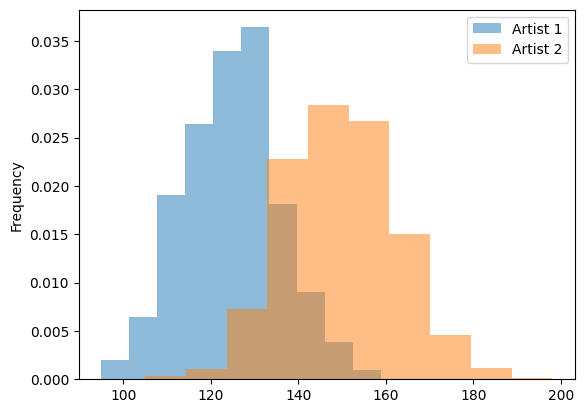

In [268]:
num_replicates = 1000

df = pd.DataFrame({
    "artist" : ['Artist 1'] * num_replicates + ['Artist 2']*num_replicates,
    "length" : np.concatenate((np.random.poisson(125,num_replicates),np.random.poisson(150,num_replicates)))
})

df.groupby('artist')['length'].plot(kind="hist",density=True,alpha=0.5,legend=True)

Since the lyrics may be stored with carriage returns or tabs, it may be useful to have a function that can collapse whitespace, using regular expressions, and be used for splitting. 

Q: What does the regular expression `'\s+'` match on? 

A: Any non-whitespace character. This can be used to remove new lines, tabs, etc.


In [19]:
collapse_whitespace = re.compile(r'\s+')

def tokenize_lyrics(lyric) : 
    """strip and split on whitespace"""
    return([item.lower() for item in collapse_whitespace.split(lyric)])

,artist,song_name,length
0,maher_zain,maherzain_paradise.txt,379.0
1,maher_zain,maherzain_yanabisalamalayka.txt,519.0
2,maher_zain,maherzain_thechosenone.txt,168.0
3,maher_zain,maherzain_yanabisalamalaykaarabicversion.txt,407.0
4,maher_zain,maherzain_thankyouallah.txt,227.0


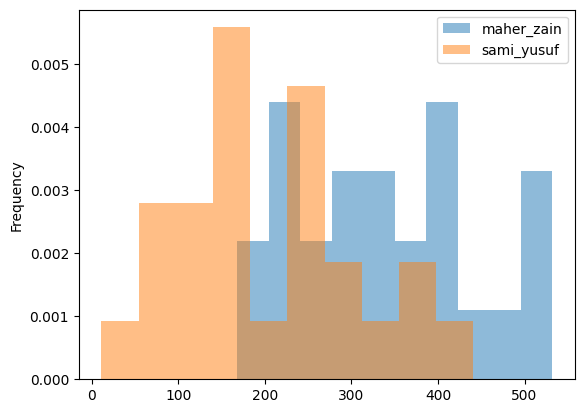

In [282]:
# Your lyric length comparison chart here. 
song_length_df = pd.DataFrame()

for artist in artists:
    parent_fld = f'/Users/nima/Downloads/lyrics/{artist}/'
    song_list = os.listdir(parent_fld)
    for song_name in song_list:
        if not '.txt' in song_name:
            continue
        with open(parent_fld+song_name, 'r') as f:
            lyric = f.read()
            
        song_length = len(tokenize_lyrics(lyric))
        last_row = len(song_length_df)
        song_length_df.loc[last_row,'artist'] = artist
        song_length_df.loc[last_row,'song_name'] = song_name
        song_length_df.loc[last_row,'length'] = song_length
        
song_length_df.groupby('artist')['length'].plot(kind="hist",density=True,alpha=0.5,legend=True)

song_length_df.head()  